In [2]:
import numpy as np
import h5py
from nnSampleVerification import plotter, signedDistanceFunction, verify

In [ ]:
betaDKW = 0.001
epsilonDKW = 0.1
Delta = 1-0.9
betaScenario = 0.001
verifScenario = verify.usingScenario(betaScenario,Delta)

# Import TaxiRun h5 using pandas
f = h5py.File('./TaxiRunFixed.h5', 'r')
tot_full_runs = 408
y_pos = np.zeros((tot_full_runs,1))

for i in np.arange(0,tot_full_runs):

    run_num = 'run_' + str(i+1)
    group = f.get(run_num)
    y_pos[i] = group.get('cte')[-1]


# Generate samples
samples = y_pos
# Add samples to the verifier
verifDKW.addSamples(samples[0:verifDKW.num_samples])    
verifScenario.addSamples(samples[0:verifScenario.num_samples])

# Center of the norm-ball
center = np.array(0.0)
zero_radius_fixed = np.array(1)
normSDF = signedDistanceFunction.norm(center,zero_radius_fixed,norm=1)

# Add SDF: 
verifDKW.addSpecification(normSDF)
verifScenario.addSpecification(normSDF)

# Run ZeroOne
verifDKW.findZeroOne(0.1)
print(verifDKW.zeroOne)

levelProb = 0.9
levelSetDKW = verifDKW.findLevelSet(levelProb)
levelSetScenario = verifScenario.findLevelSet()


print("DKW Level-Set: " + str(levelSetDKW))
print("DKW Level-Set Probability: " + str(verifDKW.empiricalCDF(levelSetDKW)))
print("Scenario Level-Set: " + str(levelSetScenario))


-----------------------------------------------------------------
Error between true and empirical CDF (i.e. \sup_x(|cdfTrue(x) - cdfEmpirical(x)|) < \epsilon): epsilon = 0.1
Confidence level (i.e. P(\sup_x(|cdfTrue(x) - cdfEmpirical(x)|) < \epsilon) >= 1-\beta): 1-beta = 0.999
Number of samples needed from simulator/sampler: 381
Please add the specification by calling "usingDKW.addSpecification()" function.
-----------------------------------------------------------------
-----------------------------------------------------------------
Confidence level (i.e. P(P(g_C(f(x)) <= 0) >= 1-\Delta) >= 1-\beta): 1-beta = 0.999, 1-Delta = 0.999
Number of samples needed from simulator/sampler: 12510
Please add the specification by calling "usingScenario.addSpecification()" function.
-----------------------------------------------------------------


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './TaxiRunFixed.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

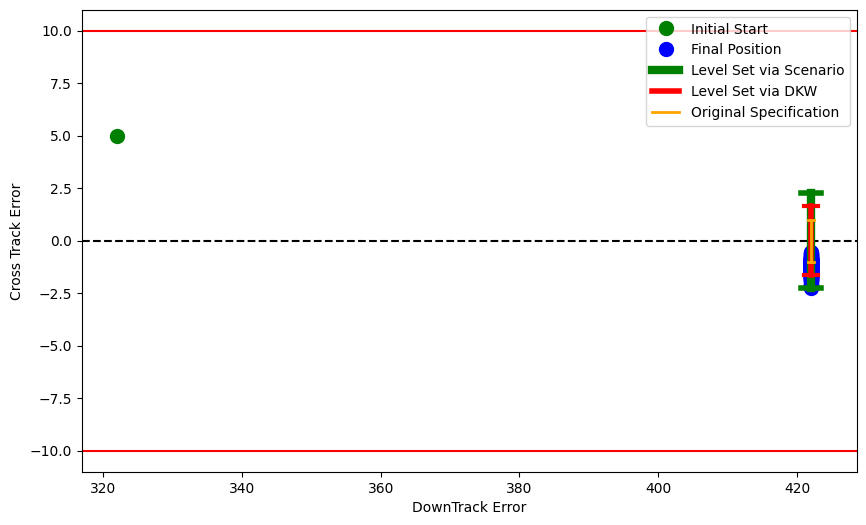

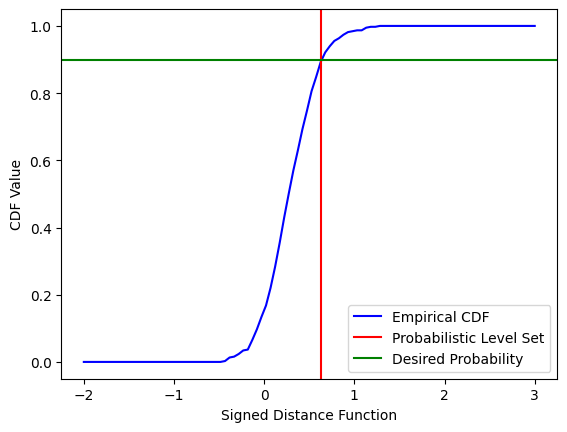

In [ ]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 6))

# Add horizontal lines at 10 and -10
plt.axhline(y=10, color='r', linestyle='-')
plt.axhline(y=-10, color='r', linestyle='-')
plt.axhline(y=0, color='k', linestyle='--')

# Plot the samples
plt.plot(322,5, 'og', label='Initial Start', markersize=10)
plt.plot(422*np.ones(samples.shape[0]),samples, 'o', label='Final Position', markersize=10, color='blue')

plt.plot([422, 422], [-1-levelSetScenario, 1+levelSetScenario], '-', color='green', linewidth=6, label='Level Set via Scenario')
plt.plot([420.5, 423.5], [1+levelSetScenario, 1+levelSetScenario], '-', color='green', linewidth=4)
plt.plot([420.5, 423.5], [-1-levelSetScenario, -1-levelSetScenario], '-', color='green',linewidth=4)
plt.plot([422, 422], [-1-levelSetDKW, 1+levelSetDKW], '-', color='red', linewidth=4, label='Level Set via DKW')
plt.plot([421, 423], [1+levelSetDKW, 1+levelSetDKW], '-', color='red', linewidth=3)
plt.plot([421, 423], [-1-levelSetDKW, -1-levelSetDKW], '-', color='red',linewidth=3)
# Add box and whisker like lines at y = ±1.5 and x = 422
plt.plot([422, 422], [-1, 1], '-', color='orange', linewidth=2)
plt.plot([421.5, 422.5], [1, 1], '-', color='orange', linewidth=2)
plt.plot([421.5, 422.5], [-1, -1], '-', color='orange',linewidth=2, label='Original Specification')




# Add labels and title
plt.xlabel('DownTrack Error')
plt.ylabel('Cross Track Error')

plt.legend(loc='best')

# Show the plot
plt.show()

evalPts = np.linspace(-2,3,100)
plotter.histogramPlot(verifDKW.empiricalCDF,evalPts,levelSetDKW,levelProb)